# Manufactured solution for BP3-like problem


The manufactured solution is going to exactly solve the following problem:

$$
\begin{aligned}
    -\frac{\partial\sigma_{ij}(\boldsymbol{u})}{\partial x_j} &= 0 & \text{ in } & \Omega \\
    \sigma_{ij} &= c_{ijkl} \frac{\partial u_k}{\partial x_l} & \text{ in } & \Omega \\
    u_i &= u_i^* & \text{ on } & \Gamma_D \\
    u_1^- - u_1^+ &= 0 & \text{ on } & \Gamma_F \\
    u_2^- - u_2^+ &= S_2 & \text{ on } & \Gamma_F \\
    u_3^- - u_3^+ &= -S_1 & \text{ on } & \Gamma_F \\
    -(\tau_i^0 + \tau_i) &= (\sigma_n^0-\sigma_n)f(|V|,\psi)\frac{V_i}{|V|} + \eta V_i & \text{ on } & \Gamma_F \\
    \frac{d\psi}{dt} &= g(|V|,\psi) + s(\vec x, t) & \text{ on } & \Gamma_F \\ 
    \frac{dS}{dt} &= V & \text{ on } & \Gamma_F
\end{aligned}
$$
where
$$
\begin{aligned}
    f(|V|, \psi) &= a \cdot \mathrm{asinh}\left(\frac{|V|}{2V_0} \exp\left(\frac{\psi}{a}\right)\right) \\
    g(|V|, \psi) &= \frac{b V_0}{L} \left(\exp\left(\frac{f_0-\psi}{b}\right) - \frac{|V|}{V_0}\right) \\
    s(\vec{x}, t) &= - g(|V^*|, \psi^*) + \frac{d\psi^*}{dt} \\
    \tau_1 &= -\sigma_{13} \\
    \tau_2 &= \sigma_{12} \\
    \sigma_n &= \sigma_{11}
\end{aligned}
$$

In [1]:
from sympy import *
init_printing()

We first define symbols and general functions, which are going to be specified later.

In [2]:
x, y, z, t = symbols('x y z t')
te, tw = symbols('t_e t_w')
V0, Vp = symbols('V_0 V_p')
a, sn, eta = symbols('a sigma_n eta')
K = Function('K')(t)
V1_star = Function('V_1^*')(z, t)
tau1_star = Function('tau_1^*')(z, t)
tau1_pre = Function('tau_1^0')(z)
sn_star = symbols('sigma_n^*')
sn_pre = Function('sigma_n^0')(z)
E, nu = symbols('E nu', real=True, positive=True)
lamda = E*nu/((1-2*nu)*(1+nu))
mu = E/(2*(1+nu))

$\psi^*$ is the state variable.

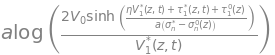

In [3]:
psi_star = a * log((2*V0/V1_star) * sinh((tau1_pre + tau1_star + eta * V1_star) / (a*(sn_star - sn_pre))))
psi_star

We need the time derivative $\frac{d\psi^*}{dt}$

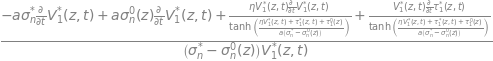

In [4]:
psi_star.diff(t).simplify()

$u_i^*$ is solution for the displacement.

In [5]:
k = symbols('k', real=True, positive=True)
f = K*x*exp(-k*x)
phi = cos(k*z)*f
phi

In [6]:
sxx = phi.diff(z, 2)
szz = phi.diff(x, 2)
sxz = -phi.diff(x).diff(z)
exx = (sxx - nu/(1-nu)*szz)*(1-nu**2)/E
ezz = (szz - nu/(1-nu)*sxx)*(1-nu**2)/E
exz = sxz*(1+nu)/E
ux_star = integrate(exx, x)
uz_star = integrate(ezz, z)
ux_star.simplify()

In [7]:
uz_star.simplify()

In [8]:
simplify(ux_star.diff(z) + uz_star.diff(x) - 2*exz)

Let's introduce slip:

In [9]:
uxm_star = ux_star.subs(k, -k)
uzm_star = uz_star.subs(k, -k)
uxp_star = ux_star
uzp_star = uz_star

In [10]:
u = Array([uxm_star, 0, uzm_star])
I = Array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
Ju = permutedims(derive_by_array(u, [x, y, z]), (1, 0))
strain = 0.5 * simplify(Ju + Ju.transpose())
stress1 = simplify(lamda * tensorcontraction(strain, (0, 1)) * I + 2.0 * mu * strain)
eq1 = simplify(stress1[0,0].diff(x) + stress1[0,1].diff(y) +  + stress1[0,2].diff(z))
eq2 = simplify(stress1[1,0].diff(x) + stress1[1,1].diff(y) +  + stress1[1,2].diff(z))
eq3 = simplify(stress1[2,0].diff(x) + stress1[2,1].diff(y) +  + stress1[2,2].diff(z))
(eq1, eq2, eq3)

In [11]:
u = Array([uxp_star, 0, uzp_star])
I = Array([[1, 0, 0], [0, 1, 0], [0, 0, 1]])
Ju = permutedims(derive_by_array(u, [x, y, z]), (1, 0))
strain = 0.5 * simplify(Ju + Ju.transpose())
stress2 = simplify(lamda * tensorcontraction(strain, (0, 1)) * I + 2.0 * mu * strain)

In [12]:
simplify((stress2-stress1).subs(x, 0))

⎡0            0                     0         ⎤
⎢                                             ⎥
⎢0  -4.0⋅k⋅ν⋅K(t)⋅cos(k⋅z)          0         ⎥
⎢                                             ⎥
⎣0            0             -4⋅k⋅K(t)⋅cos(k⋅z)⎦

$S^*$ is the on-fault displacement.

In [13]:
S1_star_fun = -(uzm_star - uzp_star).subs(x, 0).simplify()
S1_star_fun

$\tau^*$ is the on fault shear traction.

In [14]:
s13 = mu * (uxm_star.diff(z) + uzm_star.diff(x))
tau1_star_fun = -s13.subs(x, 0).simplify()
tau1_star_fun

Check continuity:

In [15]:
s13 = mu * (uxp_star.diff(z) + uzp_star.diff(x))
tau1_star_fun = -s13.subs(x, 0).simplify()
tau1_star_fun

$\sigma_n^*$ is the on fault normal stress.

In [16]:
s11 = (lamda + 2*mu) * uxm_star.diff(x) + lamda * uzm_star.diff(z)
sn_star_fun = s11.subs(x, 0).simplify()
sn_star_fun

Check continuity:

In [17]:
s11 = (lamda + 2*mu) * uxp_star.diff(x) + lamda * uzp_star.diff(z)
sn_star_fun = s11.subs(x, 0).simplify()
sn_star_fun

Slip-rate $V^*$

In [18]:
V1_star_fun = S1_star_fun.diff(t)
V1_star_fun

Acceleration $\frac{dV^*}{dt}$

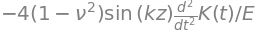

In [19]:
V1_star_fun.diff(t)

The following lines define the functions $K$ and necessary time derivatives.

In [20]:
K_fun = 2.0 * (atan((t-te)/tw) + pi/2) / pi
K_fun

In [21]:
K_fun.subs(t, 0)

In [22]:
K_fun.subs(t, te)

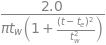

In [23]:
K_fun.diff(t)

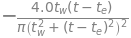

In [24]:
K_fun.diff(t).diff(t).simplify()